In [20]:
import tifffile 
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt 
import pandas as pd
from pathlib import Path

In [21]:
p = Path("C:\\Users\\jorge.cabrejas\\Desktop\\onlypores.tif")
img = tifffile.imread(p)
# img = 255 - img
# tifffile.imshow(img, cmap="gray")

In [23]:
p = Path("C:\\Users\\jorge.cabrejas\\Desktop\\test4.tif.tif")
img1 = tifffile.imread(p)
np.all(img1 == img)

True

In [3]:
labeled_image = measure.label(img)


In [7]:
#show size in mb of labeled_image
print(labeled_image.nbytes / 1e9)
labeled_image = labeled_image.astype(np.uint16)
print(labeled_image.nbytes / 1e9)

93.830196096
23.457549024


In [8]:
properties = measure.regionprops_table(labeled_image, properties=("coords",))



In [10]:
df = pd.DataFrame(properties)
df

,coords
0,"[[0, 0, 778], [0, 0, 779], [0, 0, 780], [0, 0,..."
1,"[[0, 0, 831], [0, 0, 832], [0, 0, 833], [0, 0,..."
2,"[[0, 0, 861], [0, 0, 862], [0, 0, 863], [0, 0,..."
3,"[[0, 0, 868]]"
4,"[[0, 0, 873], [0, 0, 874], [0, 0, 875], [1, 0,..."
...,...
44056,"[[1280, 5305, 1428], [1280, 5306, 1428], [1280..."
44057,"[[1280, 5326, 1432], [1280, 5327, 1432], [1280..."
44058,"[[1280, 5334, 1426], [1280, 5335, 1426]]"
44059,"[[1280, 5502, 8], [1280, 5503, 8], [1280, 5503..."


In [18]:
import gzip
import pickle
data = {"df": df, "shape": img.shape}
with gzip.open('particles.pkl.gz', 'wb') as f:
    pickle.dump(data, f)


In [19]:
import zipfile
np.savez_compressed('array_data.npz', df.to_numpy())
with open('image_shape.txt', 'w') as f:
    f.write(f'{img.shape[0]},{img.shape[1]}, {img.shape[2]}')
with zipfile.ZipFile('packed_data.zip', 'w') as zipf:
    zipf.write('array_data.npz', arcname='array_data.npz')
    zipf.write('image_shape.txt', arcname='image_shape.txt')

In [17]:
# show dataframe first row
df.memory_usage(deep=True)

Index           132
coords    955349784
dtype: int64

KeyError: 'bbox-0'

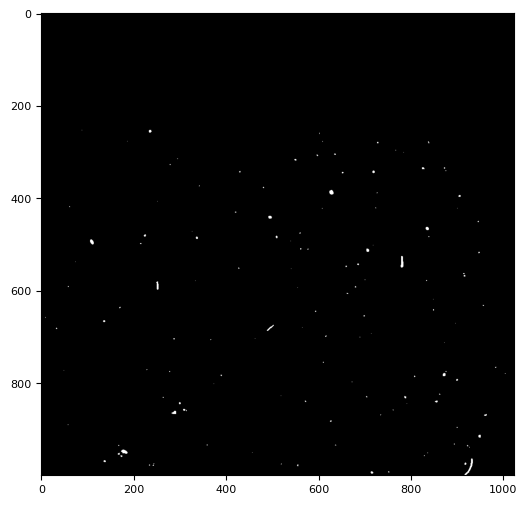

In [59]:
# plot image with all bounding boxes
fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(img, cmap="gray")
for i in range(len(df)):
    minr, minc, maxr, maxc = df['bbox-0'][i], df['bbox-1'][i], df['bbox-2'][i], df['bbox-3'][i]
    rect = plt.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)
plt.show()

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7fd860844910>)

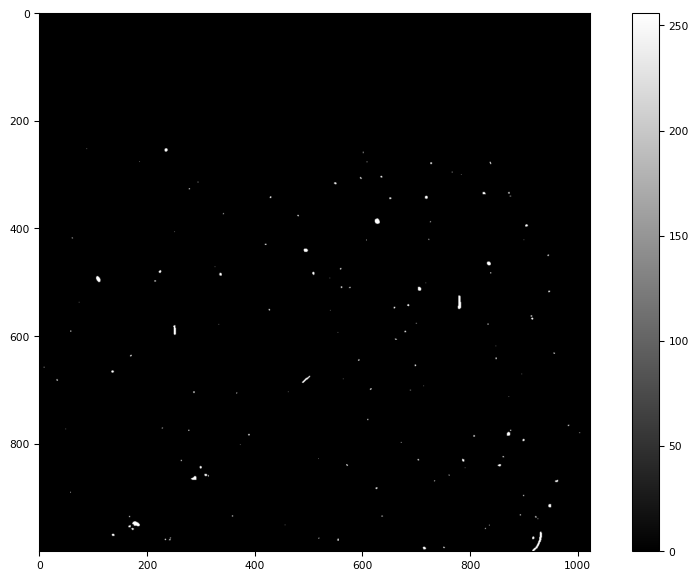

In [60]:
reconstructed_image = np.zeros_like(img)

# 2. Fill in the Pixels
for index, row in df.iterrows():
    # Get the coordinates for the current region
    coords = row['coords']
    
    # Set the pixels corresponding to the current region to 255
    for coord in coords:
        x, y = coord  # Assuming 'coords' is a list of (row, col) tuples
        reconstructed_image[x, y] = 255  # or use another value if you want a different color/label

# Optionally, display the reconstructed image
tifffile.imshow(reconstructed_image, cmap="gray")

In [61]:
csv_filename = 'particles_properties.csv'
df.to_csv(csv_filename, index=False)

In [62]:
import base64
# Convert the DataFrame to a CSV string
csv_string = df.to_csv(index=False)

# Convert the CSV string to bytes
csv_bytes = csv_string.encode()

# Encode the bytes to a base64 string
base64_encoded = base64.b64encode(csv_bytes).decode()

# Save the base64 string to a file
base64_filename = 'particles_properties_base64.txt'
with open(base64_filename, 'w') as file:
    file.write(base64_encoded)

In [63]:
import os, math

size_csv = os.path.getsize(csv_filename)
size_base64 = os.path.getsize(base64_filename)

# Function to convert bytes to KB, MB, GB, etc.
def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return f"{s} {size_name[i]}"

# Convert sizes to human-readable format (KB, MB, etc.)
size_csv_formatted = convert_size(size_csv)
size_base64_formatted = convert_size(size_base64)

print(f"Size of original CSV: {size_csv_formatted}")
print(f"Size of Base64 encoded file: {size_base64_formatted}")


Size of original CSV: 17.78 KB
Size of Base64 encoded file: 23.71 KB


In [65]:
import pickle
import gzip

# Pickle the DataFrame and compress with gzip
with gzip.open('particles.pkl.gz', 'wb') as f:
    pickle.dump(df, f)


csv_string = df.to_csv(index=False).encode('utf-8')

with gzip.open('particles.csv.gz', 'wb') as f:
    f.write(csv_string)

# Assuming 'df' is your DataFrame and it contains only numerical data
array = df.to_numpy()

# Save as a compressed .npz file
np.savez_compressed('particles.npz', array)

In [67]:
size_pkl = os.path.getsize('particles.pkl.gz')
size_csv_gz = os.path.getsize('particles.csv.gz')
size_npz = os.path.getsize('particles.npz')

size_pkl_formatted = convert_size(size_pkl)
size_csv_gz_formatted = convert_size(size_csv_gz)
size_npz_formatted = convert_size(size_npz)


print(f"Size of original CSV: {size_csv_formatted}")
print(f"Size of Base64 encoded file: {size_base64_formatted}")
print(f"Size of pickled DataFrame: {size_pkl_formatted}")
print(f"Size of compressed CSV: {size_csv_gz_formatted}")
print(f"Size of compressed NumPy array: {size_npz_formatted}")


Size of original CSV: 17.78 KB
Size of Base64 encoded file: 23.71 KB
Size of pickled DataFrame: 3.42 KB
Size of compressed CSV: 3.97 KB
Size of compressed NumPy array: 5.72 KB


In [68]:
with gzip.open('particles.pkl.gz', 'rb') as f:
    df_from_pickle = pickle.load(f)

df_from_pickle

,coords
0,"[[253, 88]]"
1,"[[253, 234], [253, 235], [253, 236], [253, 237..."
2,"[[259, 601], [260, 601], [261, 601]]"
3,"[[277, 186]]"
4,"[[277, 608], [278, 608]]"
...,...
132,"[[977, 234], [978, 233], [978, 234], [978, 235..."
133,"[[977, 554], [977, 555], [978, 554], [978, 555..."
134,"[[978, 242], [978, 243], [979, 241], [979, 242..."
135,"[[992, 713], [992, 714], [992, 715], [993, 712..."


(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7fd862d63d10>)

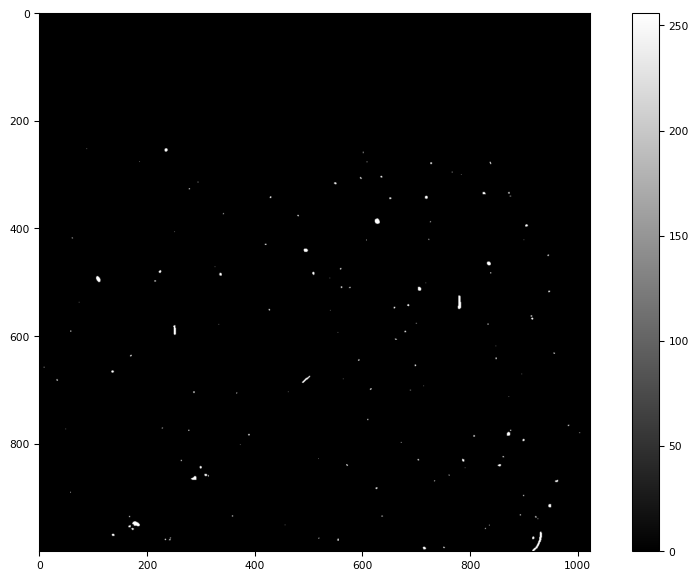

In [72]:
# Reconstruct the image from the DataFrame pkl.gz file  
reconstructed_image = np.zeros_like(img)

# 2. Fill in the Pixels
for index, row in df_from_pickle.iterrows():
    # Get the coordinates for the current region
    coords = row['coords']
    
    # Set the pixels corresponding to the current region to 255
    for coord in coords:
        x, y = coord  # Assuming 'coords' is a list of (row, col) tuples
        reconstructed_image[x, y] = 255  # or use another value if you want a different color/label

# Optionally, display the reconstructed image
tifffile.imshow(reconstructed_image, cmap="gray")


In [74]:
np.all(reconstructed_image == img)

True